In [1]:
def print_json_tree(d, indent=0):
    """Print tree of keys in JSON object.
    
    Prints the different levels of nested keys in a JSON object. When there
    are no more dictionaries to key into, prints objects type and byte-size.

    Input
    -----
    d : dict
    """
    for key,value in d.iteritems():
        print ('    ' * indent + unicode(key),)
        if isinstance(value, dict):
            print; print_json_tree(value, indent+1)
        else:
            print (":", str(type(d[key])).split("'")[1], "-", str(len(unicode(d[key]))))
            

In [2]:
import requests as rq
import os
import urllib3 
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning
def get_marvel_character_list(character_type):
    """Returns a set of one type of Marvel Characters (either superheroes or supervillains)
    
    Using the rq.get() method, request the WikiPedia page containing the list of either character type
    defined by the user, then store the .json result into a dictionary, with the continue keyword if it 
    exists. In a loop, keys into query and categorymembers to access title, which contains the character
    name to be added into a set, requests another query with the continue key. If there is a KeyError,
    Then there is no more continue data to be keyed into.
    
    Args:
        characters: string describing the type of marvel characters ("superheroes or supervillains")
        
    Returns: 
        list: a set of the character names
    """
    
    group = set()  
    
    wpage = r"https://en.wikipedia.org/w/api.php?"
    action = r"action=query"
    format = r"format=json"
    list = r"list=categorymembers"
    title = r"cmtitle=Category:Marvel_Comics_%s" % character_type
    url = wpage + "&".join([action,format,list,title])
    
    data = rq.get(url).json()
    cont = data['continue']['cmcontinue']
    
    for entry in data['query']['categorymembers']:
        group.add(entry['title'])
    while True:
        try:
            data = rq.get(url + "&cmcontinue=%s" % cont).json()
            cont = data['continue']['cmcontinue']

            for entry in data['query']['categorymembers']:
                group.add(entry['title'])
        except KeyError:
            break
    return group

def make_groups(**offline):
    """Partitions the three main groups
    
    Defines global variables for each then makes the superheroes and supervillain
    sets. If offline, the markups are already stored on the directory, so to make
    the groups, just make a set of list of files in each directory. Else, forms the 
    superheroes and supervillains from requests (takes long) and  forms the ambiguous 
    set which is the intersection then, subtracts them from each group.
    
    Args:
        offline: a keyword argument specifying if the groups should be made from 
        the existing directory or from requesting. The former is much faster as it
        just accesses the already-stored markups on each of the character folders,
        instead of requesting all over again.
    Returns:
        a tuple of superheroes, supervillains, ambiguous in that order.
    """
    
    def clean_data(data):
        """Cleans the set by removing entries with 'Category' or 'List of'."""
        for item in data.copy():
            if item.find("Category") != -1 or item.find("List of") != -1:
                data.remove(item)
        return data
    
    global superheroes, supervillains, ambiguous
    
    if offline:  # Must have the the stored directory hierarchy already.
        for group, faction in enumerate(['superheroes', 'supervillains', 'ambiguous']):  # Each file has a .txt extension
            faction_chars = [c[:-4] for c in os.listdir('characters/%s' % faction)]      # So splice each until [:-4]
            
            if group == 0:
                superheroes = clean_data(faction_chars)
                
            elif group == 1:
                supervillains = clean_data(faction_chars)
            
            elif group == 2:
                ambiguous = clean_data(faction_chars)
        
    else:          
        superheroes = get_marvel_character_list("superheroes")
        supervillains = get_marvel_character_list("supervillains")
        ambiguous = superheroes.intersection(supervillains)
        superheroes -= ambiguous
        supervillains -= ambiguous
        
    return superheroes, supervillains, ambiguous

superheroes, supervillains, ambiguous = make_groups(offline=True)

In [9]:
make_groups(offline=True)

### Part 1: Get data (main part)

For a good part of this course we will be working with data from Wikipedia. Today, your objective is to crawl a large dataset with good and bad characters from the Marvel characters.

>**Ex. 3.1.1**: From the Wikipedia API, get a list of all Marvel superheroes and another list of all Marvel supervillains. Use 'Category:Marvel_Comics_supervillains' and 'Category:Marvel_Comics_superheroes' to get the characters in each category.
1. How many superheroes are there? How many supervillains?
2. How many characters are both heroes and villains? What is the Jaccard similarity between the two groups?

>*Hint: Google something like "get list all pages in category wikimedia api" if you're struggling with the query.*

>**Ex. 3.1.2**: Using this list you now want to download all data you can about each character. However, because this is potentially Big Data, you cannot store it your computer's memory. Therefore, you have to store it in your harddrive somehow. 
* Create three folders on your computer, one for *heroes*, one for *villains*, and one for *ambiguous*.
* For each character, download the markup on their pages and save in a new file in the corresponding hero/villain/ambiguous folder.

>*Hint: Some of the characters have funky names. The first problem you may encounter is problems with encoding. To solve that you can call `.encode('utf-8')` on your markup string. Another problem you may encounter is that characters have a slash in their names. This, you should just replace with some other meaningful character.*

In [169]:
import os
def download_markups(**make):
    """comment"""
    
    global path_superheroes, path_supervillains, path_ambiguous
    if make:
        path_superheroes = "./characters/superheroes"
        path_supervillains = "./characters/supervillains"
        path_ambiguous = "./characters/ambiguous"

        os.makedirs(path_superheroes)
        os.makedirs(path_supervillains)
        os.makedirs(path_ambiguous)
    
    
    def verify_fname(string):
        """Replaces illegal file name characters in the string to blanks"""
        
        if string.find(r'"') != -1:
            string = string.replace(r'"', "",2)
        if string.find(r'/') != -1:
            string = string.replace(r'/','or')
        if string.find(r':') != -1:
            string = string.replace(r':', '')
        return string
    
    def get_contents(character):
        """Requests the markup page for one character"""
        query = r'https://en.wikipedia.org/w/api.php?format=json&action=query&titles=%s&prop=revisions&rvprop=content' % character
        datum = rq.get(query).json()
        return list(datum['query']['pages'].values())[0]['revisions'][0]['*']
    

    
    for group, chars in enumerate([superheroes, supervillains, ambiguous]):        
        if group == 0:
            for char in chars:
                path = "./characters/superheroes/%s.txt" % verify_fname(char)
                sh = open(path, 'w')
                sh.write(str(get_contents(char).encode('utf-8')))
            print("superhero markups done")
            
        elif group == 1:
            for char in chars:
                path = "./characters/supervillains/%s.txt" % verify_fname(char)
                sv = open(path, 'w')
                sv.write(str(get_contents(char).encode('utf-8')))
            print("supervillain markups done")
                         
        elif group == 2:
            for char in chars:
                path = "./characters/ambiguous/%s.txt" % verify_fname(char)
                am = open(path, 'w')
                am.write(str(get_contents(char).encode('utf-8')))
            print("ambiguous markups done")
                         
                         
download_markups()

superhero markups done
supervillain markups done
ambiguous markups done


### Part 2: Explore data

#### Page lengths

>**Ex. 3.2.1**: Extract the length of the page of each character, and plot the distribution of this variable for each class (heroes/villains/ambiguous). Can you say anything about the popularity of characters in the Marvel universe based on your visualization?

>*Hint: The simplest thing is to make a probability mass function, i.e. a normalized histogram. Use `plt.hist` on a list of page lengths, with the argument `normed=True`. Other distribution plots are fine too, though.*

In [13]:
def get_page_size(character):
    link = "https://en.wikipedia.org/w/api.php?format=json&action=query&titles=%s&prop=revisions&rvprop=size" % character
    data = rq.get(link).json()
    return list(data['query']['pages'].values())[0]['revisions'][0]['size']


In [18]:
# Construct a dictionary of char:pagesize for each group

hero_size = dict(zip(superheroes, [get_page_size(char) for char in superheroes]))
villain_size = dict(zip(supervillains, [get_page_size(char) for char in supervillains]))
amb_size = dict(zip(ambiguous, [get_page_size(char) for char in ambiguous]))

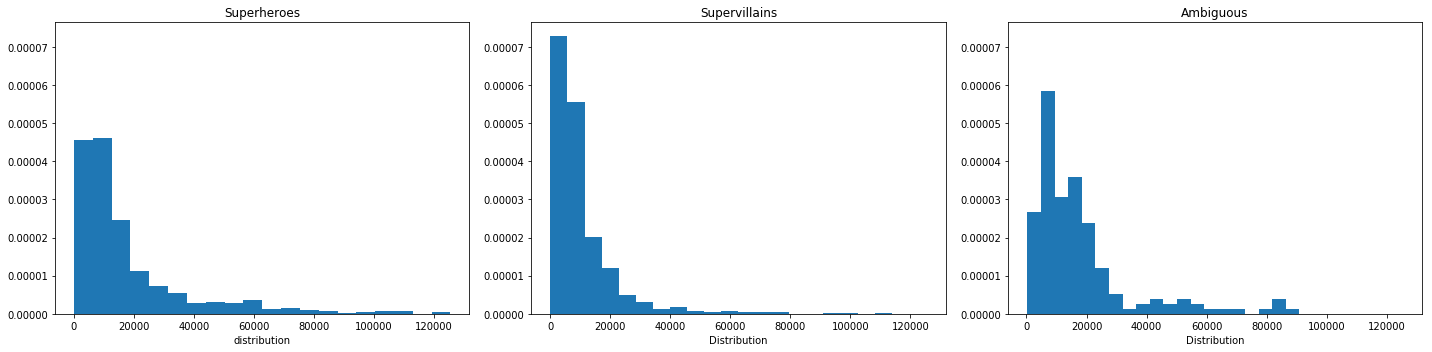

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

ax = plt.subplot(1,3,1)
plt.title("Superheroes")
plt.xlabel("distribution")
plt.hist(hero_size.values(), bins=20, density=True)

plt.subplot(1,3,2, sharex=ax, sharey=ax)
plt.title("Supervillains")
plt.xlabel("Distribution")
plt.hist(villain_size.values(), bins=20, density=True)

plt.subplot(1,3,3, sharex=ax, sharey=ax)
plt.title("Ambiguous")
plt.xlabel("Distribution")
plt.hist(amb_size.values(), bins=20, density=True)

plt.tight_layout()
plt.show()

>**Ex. 3.2.2**: Find the 10 characters from each class with the longest Wikipedia pages. Visualize their page lengths with bar charts. Comment on the result.

In [81]:
from collections import OrderedDict

sorted10_amb = OrderedDict(sorted(amb_size.items(), key=lambda x: x[1], reverse=True)[:10])
sorted10_hero = OrderedDict(sorted(hero_size.items(), key=lambda x: x[1], reverse=True)[:10])
sorted10_villain = OrderedDict(sorted(villain_size.items(), key=lambda x: x[1], reverse=True)[:10])


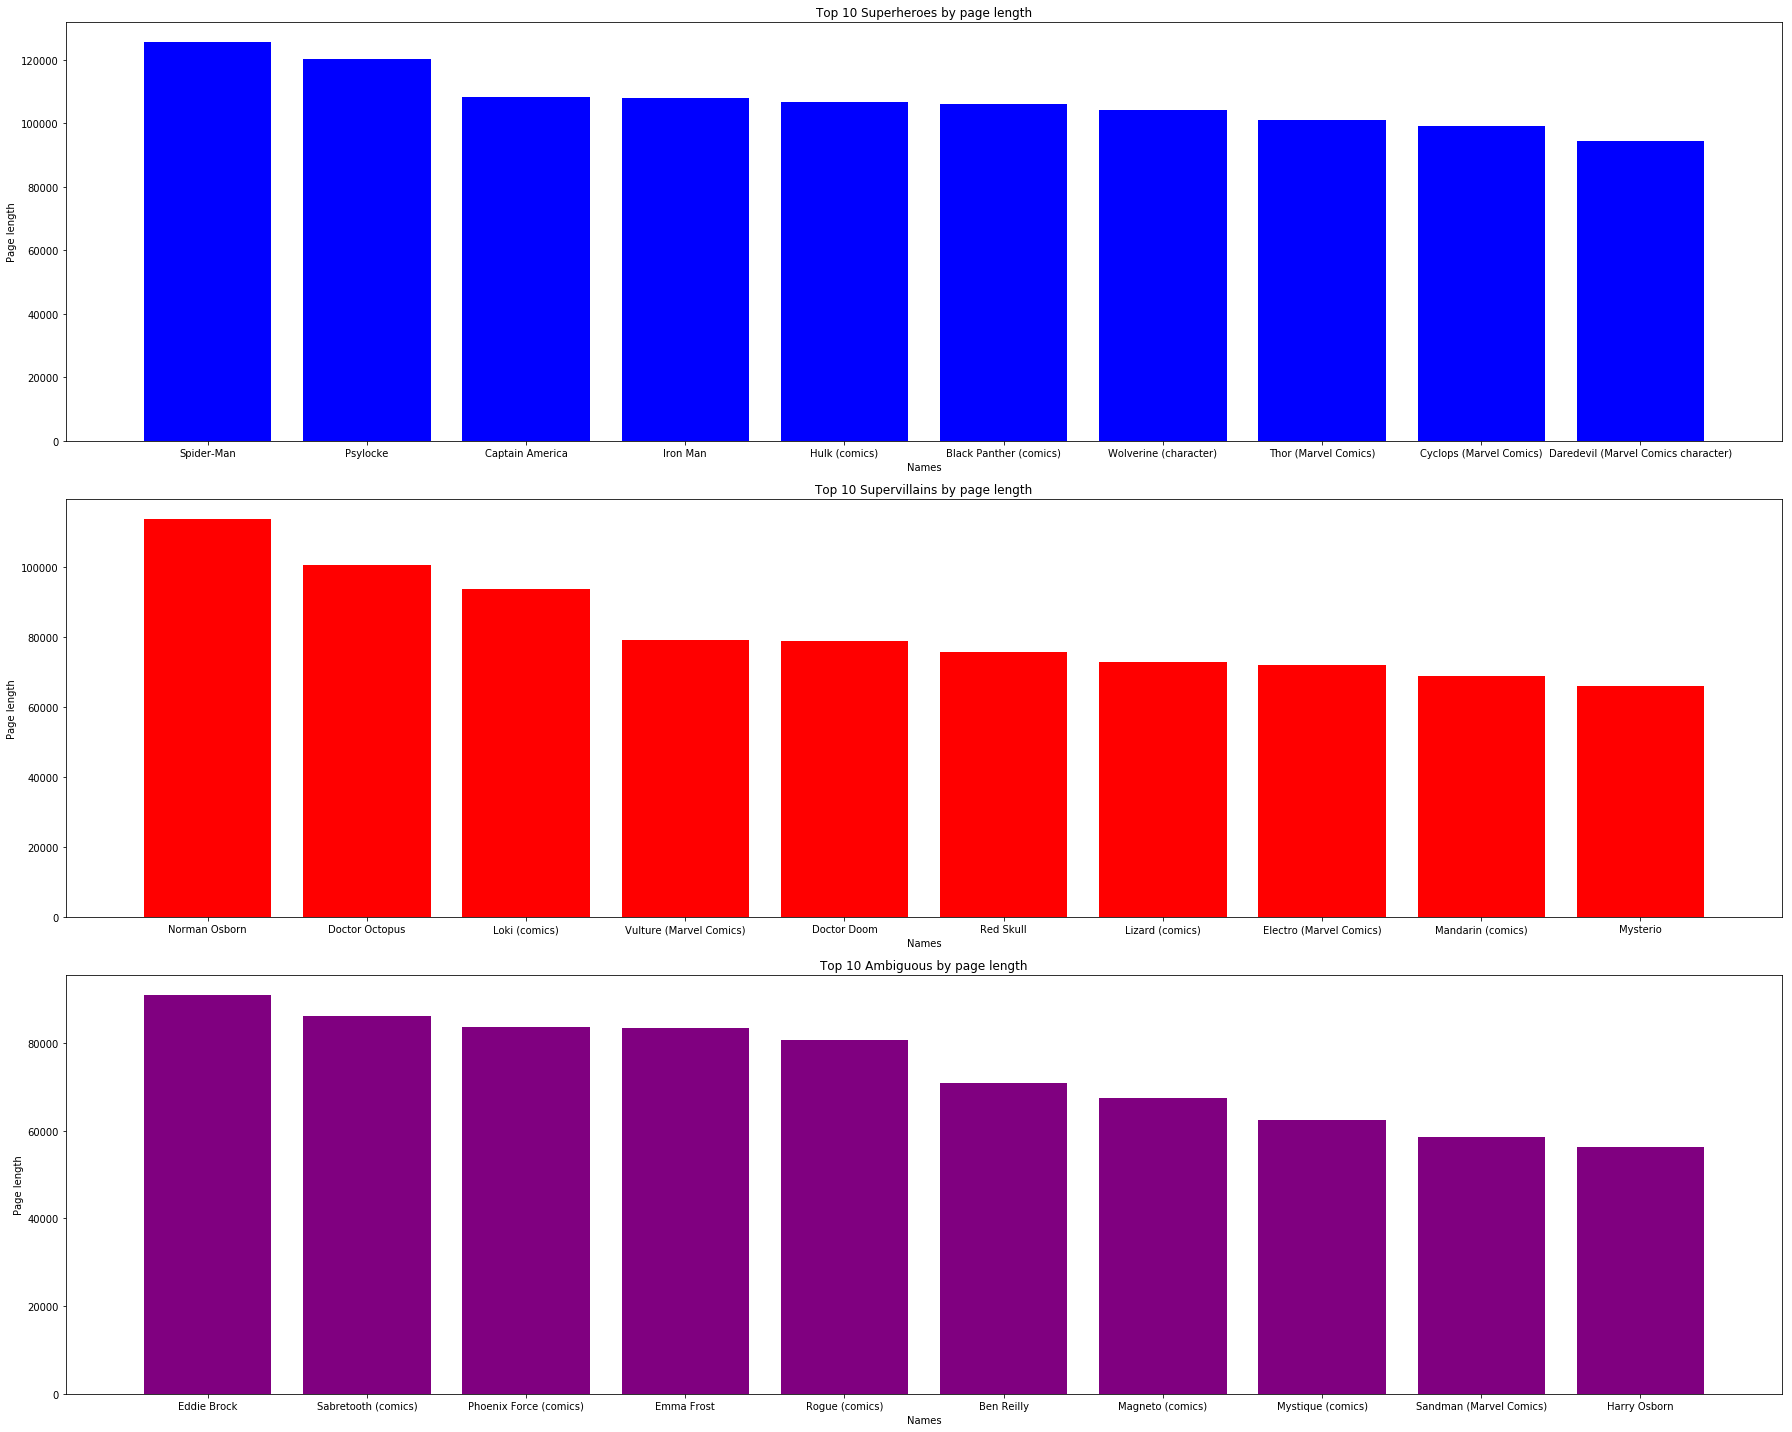

In [82]:
plt.figure(figsize=(25,20))

plt.subplot(3,1,1)
plt.title("Top 10 Superheroes by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_hero.keys(), sorted10_hero.values(),color = 'blue')

plt.subplot(3,1,2)
plt.title("Top 10 Supervillains by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_villain.keys(), sorted10_villain.values(), color = 'red')

plt.subplot(3,1,3)
plt.title("Top 10 Ambiguous by page length")
plt.xlabel("Names")
plt.ylabel("Page length")
plt.bar(sorted10_amb.keys(), sorted10_amb.values(), color = 'purple')

plt.tight_layout()
plt.show()

#### Timeline

### **Ex. 3.2.3**: We are interested in knowing if there is a time-trend in the debut of characters.
* Extract into three lists, debut years of heroes, villains, and ambiguous characters.
* Do all pages have a debut year? Do some have multiple? How do you handle these inconsistencies?
* For each class, visualize the amount of characters introduced over time. You choose how you want to visualize this data, but please comment on your choice. Also comment on the outcome of your analysis.

>*Hint: The debut year is given on the debut row in the info table of a character's Wiki-page. There are many ways that you can extract this variable. You should try to have a go at it yourself, but if you are short on time, you can use this horribly ugly regular expression code:*

>*`re.findall(r"\d{4}\)", re.findall(r"debut.+?\n", markup_text)[0])[0][:-1]`*

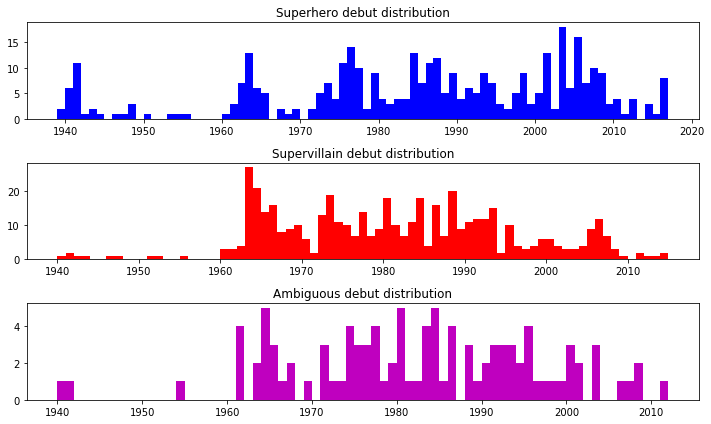

In [198]:
import re
def debut_dates():
    """Gets the debut years and plot the distribution of the characters in each group
    
    """
    
    sh_debuts = []
    sv_debuts = []
    am_debuts = []
    
    def verify_fname(string):
        """Replaces illegal file name characters in the string to blanks"""
        
        if string.find(r'"') != -1:
            string = string.replace(r'"', "",2)
        if string.find(r'/') != -1:
            string = string.replace(r'/','or')
        if string.find(r':') != -1:
            string = string.replace(r':','')
        return string

    def get_debut(char):
        for faction in ['superheroes', 'supervillains','ambiguous']:
            faction_chars = [c[:-4] for c in os.listdir("./characters/%s" % faction)]
            if char in faction_chars:
                break

        with open(r"./characters/%s/%s.txt" % (faction, char), 'r') as f:
            markup = str(f.read())

        try:
            return int(re.findall(r"\d{4}\)", str(re.findall(r"debut.+?\|", markup)))[0][:-1])
        except IndexError:
            return 0
    
        
    for group, faction in enumerate([superheroes, supervillains, ambiguous]):
        if group == 0:
            for char in faction:
                year = get_debut(verify_fname(char))
                if year != 0:
                    sh_debuts.append(year)
        elif group == 1:
            for char in faction:                
                year = get_debut(verify_fname(char))
                if year != 0:
                    sv_debuts.append(year)
        elif group == 2:
            for char in faction:
                year = get_debut(verify_fname(char))
                if year != 0:
                    am_debuts.append(year)
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(3,1,1)
    plt.title("Superhero debut distribution")
    max_bins = max(sh_debuts) - min(sh_debuts)
    plt.hist(sh_debuts,bins=max_bins,color='b')
    plt.axis('tight')
    
    plt.subplot(3,1,2)
    plt.title("Supervillain debut distribution")
    max_bins = max(sv_debuts) - min(sv_debuts)
    plt.hist(sv_debuts,bins=max_bins,color='r')
    plt.axis('tight')
    
    plt.subplot(3,1,3)
    plt.title("Ambiguous debut distribution")
    max_bins = max(am_debuts) - min(am_debuts)
    plt.hist(am_debuts,bins=max_bins, color='m')
    plt.axis('tight')
    
    plt.tight_layout()
    plt.show()
    
debut_dates()

#### Alliances

>**Ex. 3.2.4**: In this exercise you want to find out what the biggest alliances in the Marvel universe are. The data you need for doing this is in the *alliances*-field of the markup of each character. Below I suggest steps you can take to solve the problem if you get stuck.
* Write a regex that extracts the *alliances*-field of a character's markup.
* Write a regex that extracts each team from the *alliance*-field.
* Count the number of members for each team (hint: use a `defaultdict`).
* Inspect your team names. Are there any that result from inconsistencies in the information on the pages? How do you deal with this?
* **Print the 10 largest alliances and their number of members.**